Building a VAR model in Python
Analyze the time series characteristics
Test for causation amongst the time series
Test for stationarity
Transform the series to make it stationary, if needed
Find optimal order (p)
Prepare training and test datasets
Train the model
Roll back the transformations, if any.
Evaluate the model using test set
Forecast to future

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

 Import the datasets

In [7]:
df = pd.read_csv(r'C:\Users\User\Downloads\itog.txt', sep='\t',decimal=',')
print(df.shape)  # (123, 8)
df.tail()
df['Date'] = pd.to_datetime(df['t'])
df
df=df.drop(columns = ['t'],axis = 1)
df = df.set_index('Date')
df

(345, 12)


,EXCHANGERATE,CPIUSA,M1USA,M2USA,UNRATEUSA,PPIUSA,GDPUSA,CPIMEX,UNRATEMEX,PPIMEX,GDPMEX
Date,,,,,,,,,,,
1994-01-01,3.1078,146.300,773.5,3481.8,6.6,119.100,66.666081,15.915171,3.70,13.829777,14.990346
1994-01-02,3.1218,146.700,774.6,3459.7,6.6,119.300,66.666081,15.997026,3.60,13.929783,14.990346
1994-01-03,3.3026,147.100,775.1,3477.0,6.5,119.700,66.666081,16.079281,3.50,13.995880,14.990346
1994-01-04,3.3495,147.200,775.2,3507.2,6.4,119.700,66.988268,16.158030,3.60,14.113560,15.271011
1994-01-05,3.3167,147.500,775.1,3472.8,6.1,119.900,66.988268,16.236099,3.30,14.225636,15.271011
...,...,...,...,...,...,...,...,...,...,...,...
2022-01-05,20.0575,291.268,7081.7,21558.9,3.6,273.251,121.220806,138.066961,3.36,153.319376,143.951035
2022-01-06,20.0101,294.728,6973.3,21576.4,3.6,280.251,121.220806,139.232902,3.32,154.566863,143.951035
2022-01-07,20.5464,294.628,6967.1,21579.1,3.5,272.274,122.521976,140.264223,3.27,155.914041,146.044940


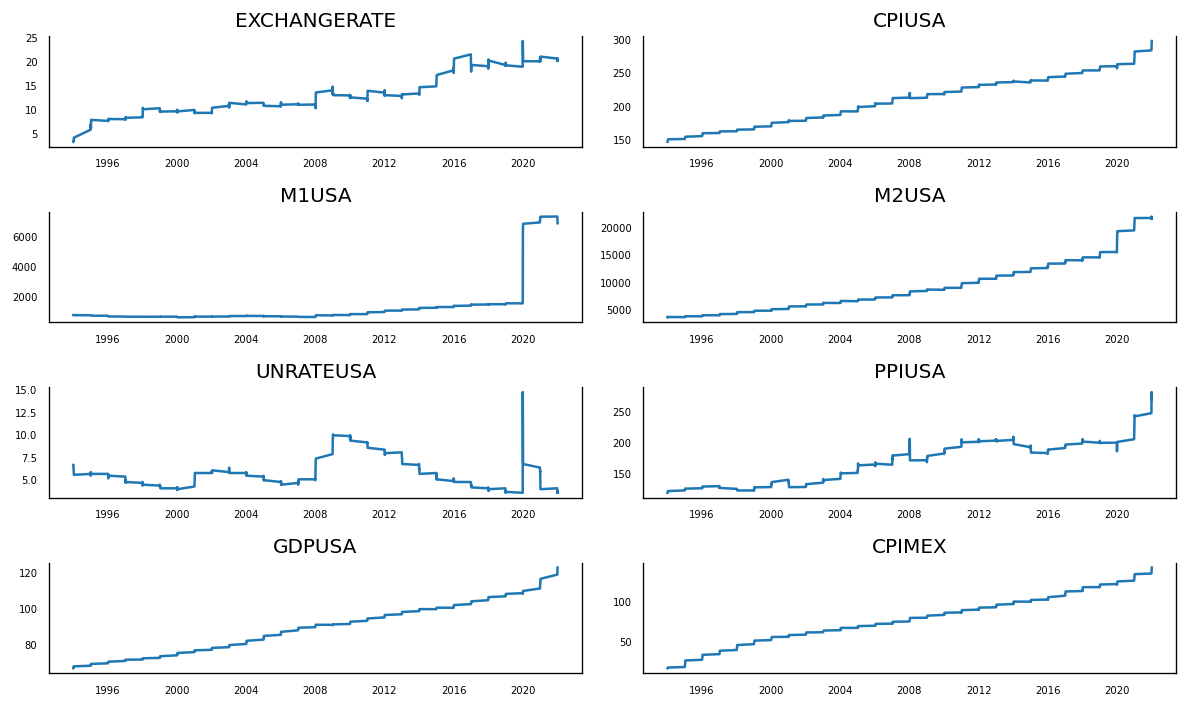

In [8]:
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

Each of the series have a fairly similar trend patterns over the years except for gdfce and gdfim, where a different pattern is noticed starting in 1980.

Alright, next step in the analysis is to check for causality amongst these series. The Granger’s Causality test and the Cointegration test can help us with that.

In [9]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table
    are the P-Values. P-Values lesser than the significance level (0.05), implies
    the Null Hypothesis that the coefficients of the corresponding past values is
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns)

,EXCHANGERATE_x,CPIUSA_x,M1USA_x,M2USA_x,UNRATEUSA_x,PPIUSA_x,GDPUSA_x,CPIMEX_x,UNRATEMEX_x,PPIMEX_x,GDPMEX_x
EXCHANGERATE_y,1.0000,0.0071,0.0291,0.0003,0.0157,0.0014,0.0064,0.0062,0.7998,0.0000,0.0008
CPIUSA_y,0.0000,1.0000,0.0000,0.0000,0.1055,0.0000,0.0000,0.1103,0.3118,0.0014,0.0069
M1USA_y,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
M2USA_y,0.0000,0.0003,0.0000,1.0000,0.0000,0.0001,0.0000,0.0000,0.7357,0.0000,0.0000
UNRATEUSA_y,0.0000,0.0031,0.0021,0.0000,1.0000,0.0313,0.2772,0.2406,0.1905,0.0000,0.1218
PPIUSA_y,0.0001,0.0002,0.0000,0.0000,0.0158,1.0000,0.0007,0.0001,0.0320,0.0092,0.0554
GDPUSA_y,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0003,0.0367,0.0007,0.0001
CPIMEX_y,0.0000,0.0058,0.0000,0.0000,0.0009,0.0168,0.0000,1.0000,0.1584,0.0000,0.0000
UNRATEMEX_y,0.0003,0.0162,0.0000,0.0024,0.0001,0.3370,0.0937,0.1504,1.0000,0.0119,0.1257
PPIMEX_y,0.0064,0.0003,0.0000,0.0000,0.0000,0.0023,0.0001,0.0068,0.5857,1.0000,0.0001


So how to read the above output?

The row are the Response (Y) and the columns are the predictor series (X).

For example, if you take the value 0.0003 in (row 1, column 2), it refers to the p-value of pgnp_x causing rgnp_y. Whereas, the 0.000 in (row 2, column 1) refers to the p-value of rgnp_y causing pgnp_x.

So, how to interpret the p-values?

If a given p-value is < significance level (0.05), then, the corresponding X series (column) causes the Y (row).

For example, P-Value of 0.0003 at (row 1, column 2) represents the p-value of the Grangers Causality test for pgnp_x causing rgnp_y, which is less that the significance level of 0.05.

So, you can reject the null hypothesis and conclude pgnp_x causes rgnp_y.

Looking at the P-Values in the above table, you can pretty much observe that all the variables (time series) in the system are interchangeably causing each other.

This makes this system of multi time series a good candidate for using VAR models to forecast.

Next, let’s do the Cointegration test.

In [44]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05):
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
EXCHANGERATE ::  391.57    > 263.2603  =>   True
CPIUSA ::  291.79    > 219.4051  =>   True
M1USA  ::  221.29    > 179.5199  =>   True
M2USA  ::  172.45    > 143.6691  =>   True
UNRATEUSA ::  132.62    > 111.7797  =>   True
PPIUSA ::  96.25     > 83.9383   =>   True
GDPUSA ::  66.07     > 60.0627   =>   True
CPIMEX ::  40.17     > 40.1749   =>   True
UNRATEMEX ::  17.69     > 24.2761   =>   False
PPIMEX ::  8.34      > 12.3212   =>   False
GDPMEX ::  2.9       > 4.1296    =>   False


8. Split the Series into Training and Testing Data


In [11]:
nobs = 60
df_train, df_test = df[0:-nobs], df[-nobs:]

# Check size
print(df_train.shape)  # (119, 8)
print(df_test.shape)  # (4, 8)

(285, 11)
(60, 11)


9. Check for Stationarity and Make the Time Series Stationary
Since the VAR model requires the time series you want to forecast to be stationary, it is customary to check all the time series in the system for stationarity.

Just to refresh, a stationary time series is one whose characteristics like mean and variance does not change over time.

So, how to test for stationarity?

There is a suite of tests called unit-root tests. The popular ones are:

Augmented Dickey-Fuller Test (ADF Test)
KPSS test
Philip-Perron test
Let’s use the ADF test for our purpose.
By the way, if a series is found to be non-stationary, you make it stationary by differencing the series once and repeat the test again until it becomes stationary.

Since, differencing reduces the length of the series by 1 and since all the time series has to be of the same length, you need to difference all the series in the system if you choose to difference at all.

Got it?

Let’s implement the ADF Test.
First, we implement a nice function (adfuller_test()) that writes out the results of the ADF test for any given time series and implement this function on each series one-by-one.



In [13]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue']
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")

In [14]:
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "EXCHANGERATE" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.3902
 No. Lags Chosen       = 6
 Critical value 1%     = -3.454
 Critical value 5%     = -2.872
 Critical value 10%    = -2.572
 => P-Value = 0.587. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "CPIUSA" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -0.515
 No. Lags Chosen       = 12
 Critical value 1%     = -3.455
 Critical value 5%     = -2.872
 Critical value 10%    = -2.572
 => P-Value = 0.8891. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "M1USA" 
    -----------------------------------------------
 Null Hypothesis: Data h

The ADF test confirms none of the time series is stationary. Let’s difference all of them once and check again.

In [16]:
# 1st difference
df_differenced = df_train.diff().dropna()

Re-run ADF test on each differenced series.


In [17]:
# ADF Test on each column of 1st Differences Dataframe
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "EXCHANGERATE" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.502
 No. Lags Chosen       = 5
 Critical value 1%     = -3.454
 Critical value 5%     = -2.872
 Critical value 10%    = -2.572
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "CPIUSA" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.9634
 No. Lags Chosen       = 11
 Critical value 1%     = -3.455
 Critical value 5%     = -2.872
 Critical value 10%    = -2.572
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "M1USA" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level

After the first difference, Real Wages (Manufacturing) is still not stationary. It’s critical value is between 5% and 10% significance level.
All of the series in the VAR model should have the same number of observations.

So, we are left with one of two choices.

That is, either proceed with 1st differenced series or difference all the series one more time.

In [18]:
# Second Differencing
df_differenced = df_differenced.diff().dropna()

Re-run ADF test again on each second differenced series.


In [19]:
# ADF Test on each column of 2nd Differences Dataframe
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "EXCHANGERATE" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -9.6506
 No. Lags Chosen       = 9
 Critical value 1%     = -3.455
 Critical value 5%     = -2.872
 Critical value 10%    = -2.572
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "CPIUSA" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.7102
 No. Lags Chosen       = 15
 Critical value 1%     = -3.455
 Critical value 5%     = -2.872
 Critical value 10%    = -2.573
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "M1USA" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Leve

# ADF Test on each column of 2nd Differences Dataframe
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

10. How to Select the Order (P) of VAR model


To select the right order of the VAR model, we iteratively fit increasing orders of VAR model and pick the order that gives a model with least AIC.

Though the usual practice is to look at the AIC, you can also check other best fit comparison estimates of BIC, FPE and HQIC.

In [21]:
model = VAR(df_differenced)
for i in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

C:\Users\User\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Lag Order = 1
AIC :  -4.970580386432812
BIC :  -3.2658579276958224
FPE :  0.006943045919457021
HQIC:  -4.2869681688575065 

Lag Order = 2
AIC :  -8.401467171633774
BIC :  -5.12565318109485
FPE :  0.00022544605894791455
HQIC:  -7.087681753081667 

Lag Order = 3
AIC :  -8.929928904249156
BIC :  -4.074888505730229
FPE :  0.0001341326226839288
HQIC:  -6.982564842284883 

Lag Order = 4
AIC :  -9.048216840470658
BIC :  -2.605744324335978
FPE :  0.00012133472218712812
HQIC:  -6.463839030456293 

Lag Order = 5
AIC :  -9.369373887998812
BIC :  -1.3311918519073274
FPE :  9.070220936408324e-05
HQIC:  -6.144517210013023 

Lag Order = 6
AIC :  -9.498569070390392
BIC :  0.14367245329216338
FPE :  8.347250045953741e-05
HQIC:  -5.629738030848857 

Lag Order = 7
AIC :  -9.425038701935469
BIC :  1.8296857284461048
FPE :  9.600586261530278e-05
HQIC:  -4.908707069817135 

Lag Order = 8
AIC :  -9.687491871267675
BIC :  3.1882132364253195
FPE :  8.092297852224625e-05
HQIC:  -4.520102308849594 

Lag Order = 

LinAlgError: 7-th leading minor of the array is not positive definite

An alternate method to choose the order(p) of the VAR models is to use the model.select_order(maxlags) method.

The selected order(p) is the order that gives the lowest ‘AIC’, ‘BIC’, ‘FPE’ and ‘HQIC’ scores.

In [22]:
x = model.select_order(maxlags=22)
x.summary()

,AIC,BIC,FPE,HQIC
0,-1.725,-1.575,0.1782,-1.664
1,-5.113,-3.310,0.006022,-4.388
2,-8.508,-5.053*,0.0002028,-7.119
3,-9.118,-4.011,0.0001114,-7.065
4,-9.272,-2.512,9.771e-05,-6.554
5,-9.688,-1.275,6.681e-05,-6.307
6,-9.944,0.1210,5.462e-05,-5.898
7,-9.975,1.742,5.723e-05,-5.265
8,-10.30,3.070,4.597e-05,-4.926
9,-10.65,4.371,3.720e-05,-4.614


11. Train the VAR Model of Selected Order(p)


In [48]:
model_fitted = model.fit(22)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 27, Mar, 2023
Time:                     19:09:14
--------------------------------------------------------------------
No. of Equations:         11.0000    BIC:                    4.23140
Nobs:                     261.000    HQIC:                  -17.6001
Log likelihood:           2811.01    FPE:                1.01550e-07
AIC:                     -32.2742    Det(Omega_mle):     7.29439e-11
--------------------------------------------------------------------
Results for equation EXCHANGERATE
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                    0.016298         0.018471            0.882           0.378
L1.EXCHANGERATE         -0.071568         0.411836           -0.174           0.862
L1.CPIUSA                0.306980        

11. Train the VAR Model of Selected Order(p)
Serial correlation of residuals is used to check if there is any leftover pattern in the residuals (errors).

What does this mean to us?

If there is any correlation left in the residuals, then, there is some pattern in the time series that is still left to be explained by the model. In that case, the typical course of action is to either increase the order of the model or induce more predictors into the system or look for a different algorithm to model the time series.
So, checking for serial correlation is to ensure that the model is sufficiently able to explain the variances and patterns in the time series.

Alright, coming back to topic.

A common way of checking for serial correlation of errors can be measured using the Durbin Watson’s Statistic.

The value of this statistic can vary between 0 and 4. The closer it is to the value 2, then there is no significant serial correlation. The closer to 0, there is a positive serial correlation, and the closer it is to 4 implies negative serial correlation.



In [49]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(df.columns, out):
    print(col, ':', round(val, 2))

EXCHANGERATE : 1.79
CPIUSA : 1.6
M1USA : 1.52
M2USA : 1.74
UNRATEUSA : 2.0
PPIUSA : 1.8
GDPUSA : 2.04
CPIMEX : 1.49
UNRATEMEX : 1.78
PPIMEX : 1.92
GDPMEX : 1.47


The serial correlation seems quite alright. Let’s proceed with the forecast.


13. How to Forecast VAR model using statsmodels


In order to forecast, the VAR model expects up to the lag order number of observations from the past data.

This is because, the terms in the VAR model are essentially the lags of the various time series in the dataset, so you need to provide it as many of the previous values as indicated by the lag order used by the model.

In [50]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]
forecast_input

22


array([[ 3.78100000e-01, -5.40000000e-01, -1.81000000e+01,
         4.70000000e+00, -2.00000000e-01, -4.00000000e-01,
         0.00000000e+00, -1.37128700e-01,  6.10000000e-01,
         2.08923900e-01,  0.00000000e+00],
       [ 5.56200000e-01,  1.47000000e-01, -6.10000000e+00,
        -7.32000000e+01, -1.00000000e-01,  1.30000000e+00,
        -8.03827000e-02, -2.48546000e-02, -5.50000000e-01,
         7.23483900e-01,  1.16529030e+00],
       [-6.26800000e-01, -2.07000000e-01,  1.42000000e+01,
        -4.05000000e+01,  3.00000000e-01, -4.00000000e-01,
         8.03827000e-02,  5.91368000e-02,  3.60000000e-01,
         1.09452100e-01, -1.16529030e+00],
       [-1.17130000e+00,  1.06000000e+00, -8.70000000e+00,
         1.52600000e+02, -8.88178420e-16,  2.10000000e+00,
         0.00000000e+00, -2.95683700e-01, -1.60000000e-01,
        -1.51198660e+00,  0.00000000e+00],
       [ 6.52100000e-01,  1.68000000e-01,  7.00000000e+00,
        -6.09000000e+01,  0.00000000e+00,  3.00000000e-01,
  

In [51]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df.index[-nobs:], columns=df.columns + '_2d')
df_forecast

,EXCHANGERATE_2d,CPIUSA_2d,M1USA_2d,M2USA_2d,UNRATEUSA_2d,PPIUSA_2d,GDPUSA_2d,CPIMEX_2d,UNRATEMEX_2d,PPIMEX_2d,GDPMEX_2d
Date,,,,,,,,,,,
2017-01-10,-1.485588,2.220138,29.268211,23.688349,-0.235812,0.623791,0.616063,-1.639505,-1.028326,-0.847994,1.243622
2017-01-11,2.860011,-4.108959,-60.698402,-195.722713,0.521669,-4.893616,-1.109860,0.320641,1.272887,2.695053,-1.429344
2017-01-12,-1.292813,1.601249,35.808425,234.971324,-0.110104,3.581782,0.188259,-0.311446,-1.639517,-0.399091,-0.059350
2018-01-01,0.828581,-0.151337,27.364187,-37.165859,0.737092,-0.189314,0.349348,1.065201,1.268032,-0.240322,-2.248154
2018-01-02,-2.335935,-2.964105,8.799700,9.515033,-0.820716,-7.603889,-0.611934,-0.616803,0.560103,-3.730859,1.191524
2018-01-03,2.298123,-3.723741,23.847216,188.357676,-0.090637,-5.880644,-0.063544,0.780868,0.209257,1.402906,0.480922
2018-01-04,-0.587344,4.382059,-33.868857,-96.247135,1.267485,9.055582,0.484186,-0.701262,-0.869651,-1.663383,2.671941
2018-01-05,0.462377,1.597962,8.538210,-310.577394,-1.370168,3.833980,0.062880,-0.058939,0.098563,1.059112,-2.139365
2018-01-06,0.575827,1.778493,-38.839614,362.524740,0.405739,-3.176262,-0.231149,-0.014384,0.963175,0.213099,-0.624373


The forecasts are generated but it is on the scale of the training data used by the model. So, to bring it back up to its original scale, you need to de-difference it as many times you had differenced the original input data.

In this case it is two times.

14. Invert the transformation to get the real forecast


In [52]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [53]:
df_train

,EXCHANGERATE,CPIUSA,M1USA,M2USA,UNRATEUSA,PPIUSA,GDPUSA,CPIMEX,UNRATEMEX,PPIMEX,GDPMEX
Date,,,,,,,,,,,
1994-01-01,3.1078,146.300,773.5,3481.8,6.6,119.1,66.666081,15.915171,3.70,13.829777,14.990346
1994-01-02,3.1218,146.700,774.6,3459.7,6.6,119.3,66.666081,15.997026,3.60,13.929783,14.990346
1994-01-03,3.3026,147.100,775.1,3477.0,6.5,119.7,66.666081,16.079281,3.50,13.995880,14.990346
1994-01-04,3.3495,147.200,775.2,3507.2,6.4,119.7,66.988268,16.158030,3.60,14.113560,15.271011
1994-01-05,3.3167,147.500,775.1,3472.8,6.1,119.9,66.988268,16.236099,3.30,14.225636,15.271011
...,...,...,...,...,...,...,...,...,...,...,...
2017-01-05,18.7666,244.004,1441.0,13466.5,4.4,192.8,102.560411,108.066807,3.61,115.601923,111.992809
2017-01-06,18.1293,244.163,1443.7,13520.1,4.3,193.6,102.560411,108.338493,3.27,114.703235,111.992809
2017-01-07,17.8081,244.243,1452.9,13577.9,4.3,193.5,103.074931,108.748165,3.24,113.854431,113.418379


In [54]:
df_results = invert_transformation(df_train, df_forecast, second_diff=True)
df_results.loc[:, ['EXCHANGERATE_forecast', 'CPIUSA_forecast', 'M1USA_forecast', 'M2USA_forecast',
                   'UNRATEUSA_forecast', 'PPIUSA_forecast', 'GDPUSA_forecast', 'CPIMEX_forecast','UNRATEMEX_forecast','PPIMEX_forecast','GDPMEX_forecast']]

,EXCHANGERATE_forecast,CPIUSA_forecast,M1USA_forecast,M2USA_forecast,UNRATEUSA_forecast,PPIUSA_forecast,GDPUSA_forecast,CPIMEX_forecast,UNRATEMEX_forecast,PPIMEX_forecast,GDPMEX_forecast
Date,,,,,,,,,,,
2017-01-10,16.378512,249.907138,1464.168211,13768.688349,3.964188,196.423791,103.690994,108.329962,2.381674,114.180640,114.662001
2017-01-11,17.786536,249.270317,1418.538019,13642.553986,4.150045,193.153965,103.197197,107.353063,2.686235,116.522504,114.476279
2017-01-12,17.901746,250.234745,1408.716254,13751.390946,4.225798,193.465922,102.891659,106.064716,1.351279,118.465277,114.231208
2018-01-01,18.845537,251.047836,1426.258675,13823.062047,5.038643,193.588564,102.935469,105.841571,1.284355,120.167729,111.737981
2018-01-02,17.453394,248.896823,1452.600797,13904.248182,5.030772,186.107317,102.367345,105.001623,1.777534,118.139321,110.436279
2018-01-03,18.359374,243.022068,1502.790135,14173.791992,4.932264,172.745426,101.735678,104.942542,2.479970,117.513819,109.615499
2018-01-04,18.678010,241.529373,1519.110616,14347.088667,6.101242,168.439117,101.588198,104.182199,2.312754,115.224934,111.466660
2018-01-05,19.459023,241.634639,1543.969306,14209.807947,5.900051,167.966788,101.503597,103.362918,2.244102,113.995161,111.178457
2018-01-06,20.815863,243.518397,1529.988383,14435.051967,6.104599,164.318197,101.187847,102.529254,3.138624,112.978488,110.265880


The forecasts are back to the original scale. Let’s plot the forecasts against the actuals from test data.



15. Plot of Forecast vs Actuals


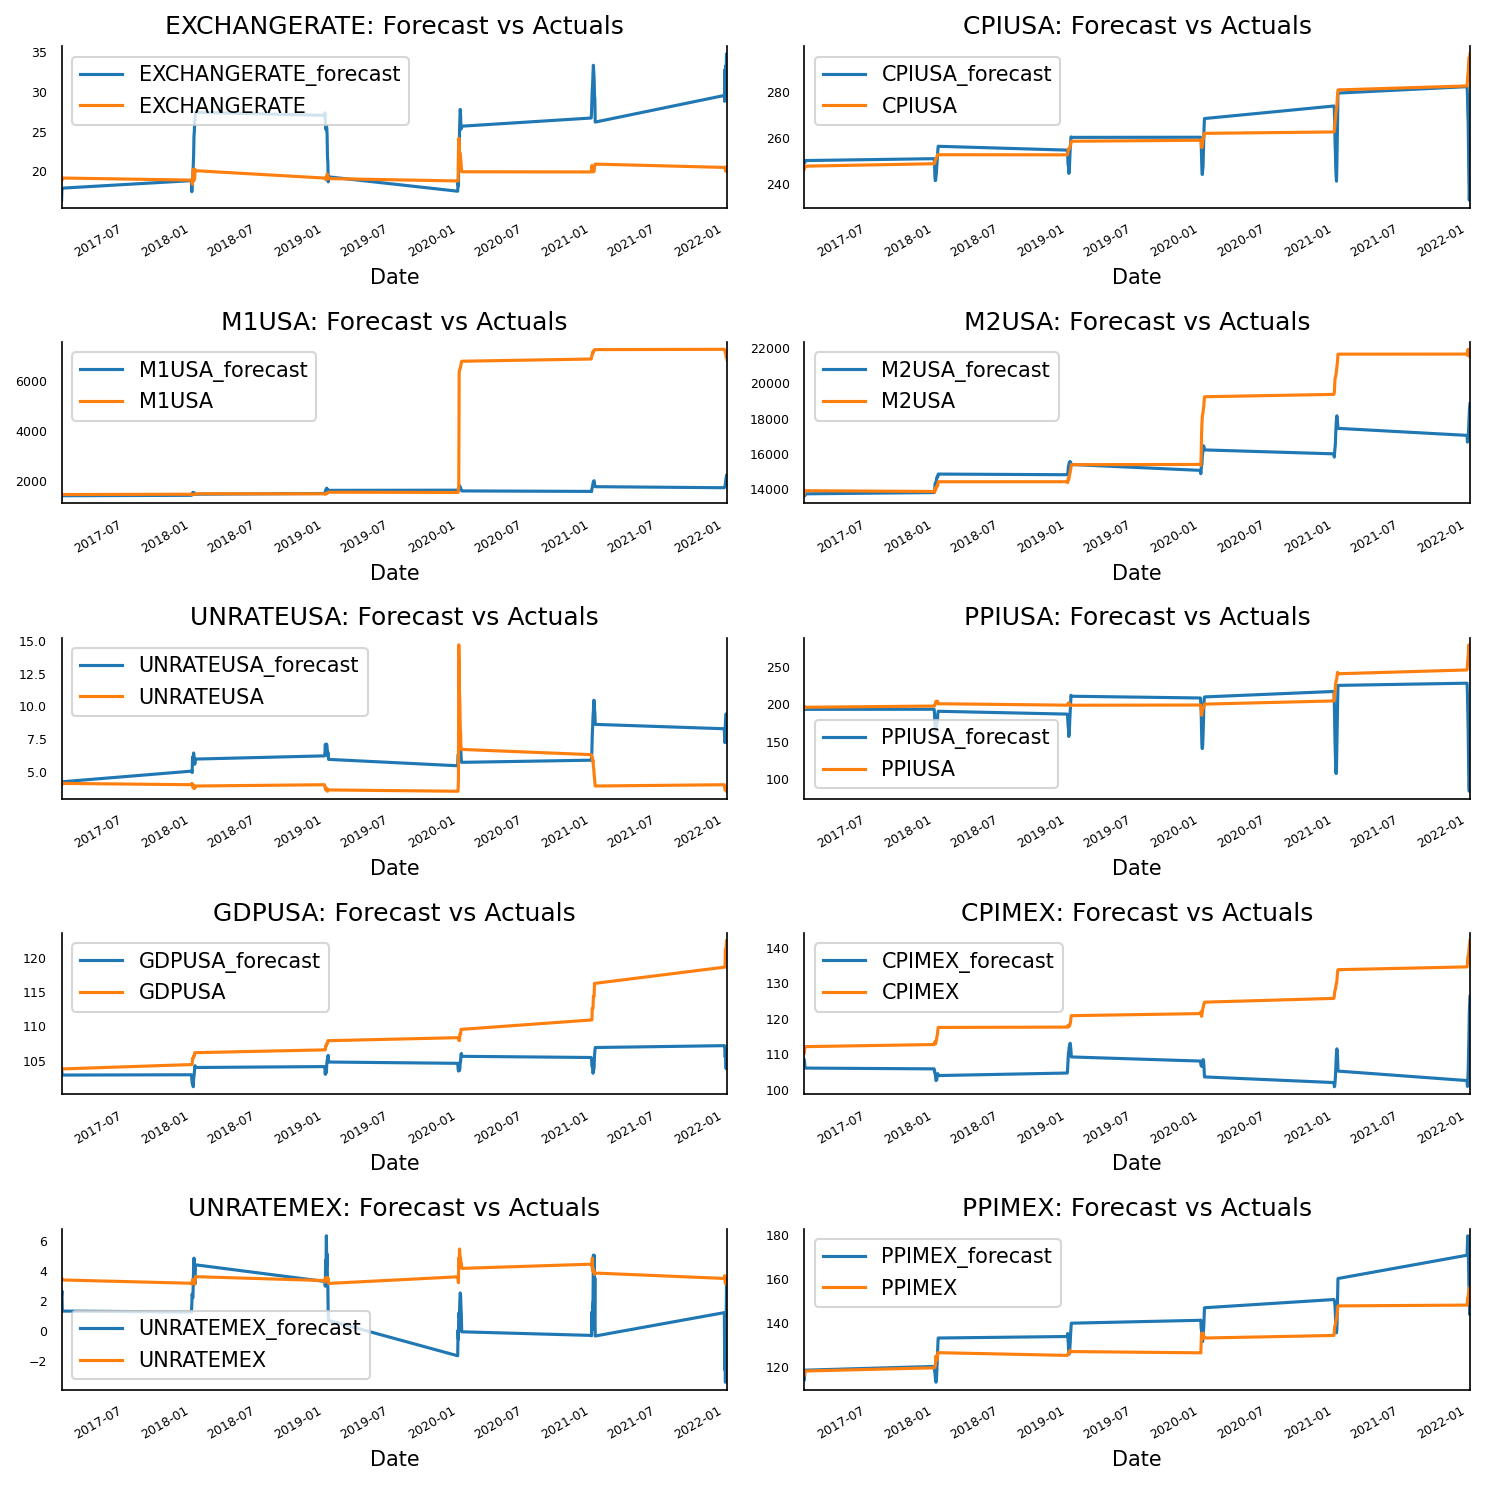

In [55]:
fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

16. Evaluate the Forecasts


To evaluate the forecasts, let’s compute a comprehensive set of metrics, namely, the MAPE, ME, MAE, MPE, RMSE, corr and minmax.



In [56]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None],
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None],
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae,
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})



print('Forecast Accuracy of: EXCHANGERATE')
accuracy_prod = forecast_accuracy(df_results['EXCHANGERATE_forecast'].values, df_test['EXCHANGERATE'])
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))

print('\nForecast Accuracy of: CPIUSA')
accuracy_prod = forecast_accuracy(df_results['CPIUSA_forecast'].values, df_test['CPIUSA'])
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))

print('\nForecast Accuracy of: M1USA')
accuracy_prod = forecast_accuracy(df_results['M1USA_forecast'].values, df_test['M1USA'])
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))

print('\nForecast Accuracy of: M2USA')
accuracy_prod = forecast_accuracy(df_results['M2USA_forecast'].values, df_test['M2USA'])
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))

print('\nForecast Accuracy of: UNRATEUSA')
accuracy_prod = forecast_accuracy(df_results['UNRATEUSA_forecast'].values, df_test['UNRATEUSA'])
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))

print('\nForecast Accuracy of: PPIUSA')
accuracy_prod = forecast_accuracy(df_results['PPIUSA_forecast'].values, df_test['PPIUSA'])
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))

print('\nForecast Accuracy of: GDPUSA')
accuracy_prod = forecast_accuracy(df_results['GDPUSA_forecast'].values, df_test['GDPUSA'])
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))

print('\nForecast Accuracy of: CPIMEX')
accuracy_prod = forecast_accuracy(df_results['CPIMEX_forecast'].values, df_test['CPIMEX'])
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))

print('\nForecast Accuracy of: UNRATEMEX')
accuracy_prod = forecast_accuracy(df_results['UNRATEMEX_forecast'].values, df_test['UNRATEMEX'])
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))

print('\nForecast Accuracy of: PPIMEX')
accuracy_prod = forecast_accuracy(df_results['PPIMEX_forecast'].values, df_test['PPIMEX'])
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))

print('\nForecast Accuracy of: GDPMEX')
accuracy_prod = forecast_accuracy(df_results['GDPMEX_forecast'].values, df_test['GDPMEX'])
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))

Forecast Accuracy of: EXCHANGERATE
mape :  0.2998
me :  5.4541
mae :  6.0269
mpe :  0.2723
rmse :  7.2642
corr :  0.2438
minmax :  0.213

Forecast Accuracy of: CPIUSA
mape :  0.0408
me :  -9.3564
mae :  11.2594
mpe :  -0.0334
rmse :  18.2487
corr :  0.2085
minmax :  0.0407

Forecast Accuracy of: M1USA
mape :  0.3822
me :  -2445.322
mae :  2516.3231
mpe :  -0.3347
rmse :  3567.4747
corr :  0.7174
minmax :  0.3804

Forecast Accuracy of: M2USA
mape :  0.0934
me :  -1488.014
mae :  1825.4085
mpe :  -0.0701
rmse :  2409.1813
corr :  0.9153
minmax :  0.093

Forecast Accuracy of: UNRATEUSA
mape :  0.6689
me :  1.9194
mae :  2.9728
mpe :  0.5711
rmse :  3.4989
corr :  -0.1093
minmax :  0.3731

Forecast Accuracy of: PPIUSA
mape :  0.1922
me :  -42.2851
mae :  44.6357
mpe :  -0.1805
rmse :  65.2957
corr :  -0.4428
minmax :  0.1919

Forecast Accuracy of: GDPUSA
mape :  0.053
me :  -6.0455
mae :  6.0455
mpe :  -0.053
rmse :  7.6589
corr :  0.6099
minmax :  0.053

Forecast Accuracy of: CPIMEX
mape 

<ipython-input-56-2352471525f2>:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)
<ipython-input-56-2352471525f2>:12: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)
